In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.1.0
!pip install --upgrade gensim --user
# tf.compat.v1.disable_v2_behavior()
!pip install -q pyyaml h5py  # Required to save models in HDF5 format
!pip install np_utils
!pip install --upgrade --user keras
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()

2.1.0


'/device:GPU:0'

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import pandas as pd
import json
import os
import glob
import pickle
#from os import path
# import malaya

In [4]:
df_allnews_unpickled = pd.read_pickle("./malaya_fake_news_preprocessed_dataframe.pkl")        #Load FakeNews Dataset from your path
df_allnews_unpickled

,news,tokens,rejoined,length,label,real,fake
0,demi lovato telah jujur kejam tentang pertempu...,"[demi, lovato, telah, jujur, kejam, tentang, p...",demi lovato telah jujur kejam tentang pertempu...,448,1,1,0
1,selamat pagi inilah yang perlu anda ketahui se...,"[selamat, pagi, inilah, yang, perlu, anda, ket...",selamat pagi inilah yang perlu anda ketahui se...,682,1,1,0
2,tahniah untuk bintang glee lea michele pelakon...,"[tahniah, untuk, bintang, glee, lea, michele, ...",tahniah untuk bintang glee lea michele pelakon...,247,1,1,0
3,ia adalah satu kejutan yang mengejutkan untuk ...,"[ia, adalah, satu, kejutan, yang, mengejutkan,...",ia adalah satu kejutan yang mengejutkan untuk ...,718,1,1,0
4,transkrip minggu ini dengan george stephanopou...,"[transkrip, minggu, ini, dengan, george, steph...",transkrip minggu ini dengan george stephanopou...,668,1,1,0
...,...,...,...,...,...,...,...
37587,katie holmes tidak mengandung anak jamie foxx ...,"[katie, holmes, tidak, mengandung, anak, jamie...",katie holmes tidak mengandung anak jamie foxx ...,336,0,0,1
37588,donald trump menegaskan bahawa serangan siber ...,"[donald, trump, menegaskan, bahawa, serangan, ...",donald trump menegaskan bahawa serangan siber ...,248,1,1,0
37589,ia bukan cerita pertama yang bermula dengan pe...,"[ia, bukan, cerita, pertama, yang, bermula, de...",ia bukan cerita pertama yang bermula dengan pe...,663,1,1,0
37590,presiden donald trump mengumumkan bahawa dia t...,"[presiden, donald, trump, mengumumkan, bahawa,...",presiden donald trump mengumumkan bahawa dia t...,100,1,1,0


In [5]:
count = df_allnews_unpickled['label'].value_counts() 
print(count) 

1    25030
0    12562
Name: label, dtype: int64


In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import tensorflow as tf
from __future__ import division, print_function
import gensim
from gensim import models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
# from keras.layers.recurrent import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Build vocabulary for all the words inside the dataframe

In [7]:
all_words = [word for tokens in df_allnews_unpickled["tokens"] for word in tokens]
all_sentence_lengths = [len(tokens) for tokens in df_allnews_unpickled["tokens"]]
ave_sentence_lengths = sum(all_sentence_lengths)/len(all_sentence_lengths)
ALL_VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(ALL_VOCAB)))
print("Max sentence length is %s" % max(all_sentence_lengths))
print("Average sentence length is %s" % ave_sentence_lengths)

16195904 words total, with a vocabulary size of 186872
Max sentence length is 991
Average sentence length is 430.8337944243456


Load Word2Vec Model

In [8]:
from gensim.models.callbacks import CallbackAny2Vec

loss_list = list()

# # This function is only redefined because the Malay Word2Vec is trained with this function
# # For some reason, gensim could not Word2Vec without this function
# # Not used in this Notebook
class LossLogger(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subbed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subbed
        loss_list.append(loss_now)
        self.loss_to_be_subbed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [9]:
word2vec_path = './mswiki.model'
# word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
# word2vec = gensim.models.KeyedVectors.load(word2vec_path)
word2vec = gensim.models.Word2Vec.load(word2vec_path)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Convert list (of words) into sequences (of int) based on the vocabulary list.
<br> Add reserved indices at the beginning of the converted sequence.

In [10]:
tokenizer = Tokenizer(num_words=len(ALL_VOCAB), lower=True, char_level=False, oov_token='<UNK>')
tokenizer.fit_on_texts(df_allnews_unpickled["tokens"].tolist())
sequences_all = tokenizer.texts_to_sequences(df_allnews_unpickled["tokens"].tolist())

for i in range(len(sequences_all)):
  for j in range(len(sequences_all[i])):
    sequences_all[i][j] += 2         # # The first 4 [0,1,2,3] indices are reserved
sequences_all = [[1] + sub for sub in sequences_all]    #at <START> tag at the beginning of all subitems

all_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(all_word_index))


# # The first 4 [0,1,2,3] indices are reserved
# all_word_index = {k:(v+2) for k,v in all_word_index.items()}
for key, value in all_word_index.items():
  all_word_index[key] += 2
all_word_index["<PAD>"] = 0
all_word_index["<START>"] = 1
all_word_index["<UNUSED>"] = 2
all_word_index["<UNK>"] = 3  # unknown

Found 186873 unique tokens.


In [11]:
all_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(all_word_index))

Found 186876 unique tokens.


Define function(s) to decode sequences back to text

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in all_word_index.items()])
def decode_news(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [13]:
# MAX_SEQUENCE_LENGTH = 50
# MAX_SEQUENCE_LENGTH = 128
MAX_SEQUENCE_LENGTH = max(all_sentence_lengths)
EMBEDDING_DIM = 300
print (MAX_SEQUENCE_LENGTH)
print (EMBEDDING_DIM)

991
300


Pad the sequence by MAX_SEQUENCE_LENGTH

In [ ]:
# train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
all_data = pad_sequences(sequences_all, value=all_word_index["<PAD>"], padding='post', truncating='post', maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
print (all_data[1])
print (sequences_all[1])

Initialize Embedding Layer weights based on Word2Vec values.
<br> The embedding will be initialized randomly for words that does not exist in Word2Vec model.

In [14]:
count_vpre = 0

embedding_weights = np.zeros((len(all_word_index), EMBEDDING_DIM))
for word,index in all_word_index.items():
  # embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
  if word in word2vec:
    embedding_weights[index,:] = word2vec[word]
    count_vpre += 1
  else:
    embedding_weights[index,:] = np.random.RandomState(3435).rand(EMBEDDING_DIM)


print(embedding_weights.shape)
print("Number of words present in the set of pre-trained word vectors %s" % count_vpre)

(186876, 300)
Number of words present in the set of pre-trained word vectors 60562


In [ ]:
idx = 8

for key, value in all_word_index.items():
  if value == idx:
    print(key, value)

print(embedding_weights[idx])

In [ ]:
label_names = ['real', 'fake']
labels_list = df_allnews_unpickled[label_names].values
# print (labels_list[42])
# print (sequences_all[42])
# # Zip back the news and labels into a temporary list
all_newsnlabels = list(zip(all_data, labels_list))
# print (all_newsnlabels[42][0])
# print (all_newsnlabels[42][1])

Define CNN Architecture

In [ ]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=100, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.5)(l_merge)  
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(all_word_index), 
                EMBEDDING_DIM, len(list(label_names)))


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 994)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 994, 300)     57945300    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 992, 100)     90100       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 991, 100)     120100      embedding_1[0][0]                
____________________________________________________________________________________________

In [ ]:
model.save_weights('./cnn/cnn_model_10fold.h5')

In [ ]:
model.load_weights('./cnn/cnn_model_10fold.h5')

In [ ]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights()) # list of numpy arrays

print ((weights[2][0]))

K-fold Cross Validation stars here

In [ ]:
num_folds = 10
num_epochs = 4
batch_size = 50
fold_no = 1
kfold = KFold(n_splits=num_folds, shuffle=False)

In [ ]:
# data_train, data_test = train_test_split(all_newsnlabels, test_size=0.10, random_state=42)
inputs = all_data
targets = labels_list
print (len(inputs))
print (len(targets))

# x_train = np.asarray([row[0] for row in data_train])
# y_train = np.asarray([row[1] for row in data_train])
# x_test = np.asarray([row[0] for row in data_test])
# y_test = np.asarray([row[1] for row in data_test])
# print (x_train[42])
# print (y_train[42])
# print (inputs[39505])
# print (targets[39505])

In [ ]:
fold_no = 1
results_history = []

acc_per_fold = []
loss_per_fold = []

# # Lists for metrics result
all_accuracy = []
all_precision = []
all_recall = []
all_f1 = []

# # Lists for plotting Precision-Recall Curve
all_arr_precision = []
all_arr_recall = []
all_thresholds = []
all_ave_precision = []

# # Lists for Confusion Matrices
all_cf_matrices = []

for train, test in kfold.split(inputs, targets):
  model.load_weights('./cnn/cnn_model_10fold.h5')     #Load the same initial weights for all splits
  x_train = np.asarray(inputs[train])
  y_train = np.asarray(targets[train])
  x_test = np.asarray(inputs[test])
  y_test = np.asarray(targets[test])
  
  # # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  checkpoint_path = "./cnn/cnn_training_10fold/cp_10fold_{}.ckpt".format(fold_no)
  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
  
  hist = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test,y_test),     #validation_split = 0.1,
                 shuffle=True, batch_size=batch_size, callbacks=None)    #callbacks=[cp_callback]
  
  # results_history.append(hist)
  results_history.append(hist.history)

  #EVALUATE MODEL ON TEST SET
  results_scores = model.evaluate(x_test, y_test)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {results_scores[0]}; {model.metrics_names[1]} of {results_scores[1]*100}%')
  acc_per_fold.append(results_scores[1] * 100)
  loss_per_fold.append(results_scores[0])


  # METRICS CALCULATION STARTS HERE
  # predict probabilities for test set
  yhat_probs = model.predict(x_test, verbose=0)
  # y_probs = np.max(yhat_probs, axis=1)  #Predicted Probabilities
  y_probs = yhat_probs[:, 0] #Predicted Probabilities     #Consider only positive-predicted class for Precision Recall Curve
  
  # predict crisp classes for test set
  ## supposed use argmax but index of labels are arranged as [real, fake] = [0, 1]
  ## argmin is used to invert and get [1, 0] instead
  yhat_classes = yhat_probs.argmin(axis=-1)   #Predicted Classes
  y_test_conv = y_test.argmin(axis=-1)        #Actual Classes
  
  ## Metrics calculation
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_test_conv, yhat_classes)
  all_accuracy.append(accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(y_test_conv, yhat_classes)
  all_precision.append(precision)
  # recall: tp / (tp + fn)
  recall = recall_score(y_test_conv, yhat_classes)
  all_recall.append(recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test_conv, yhat_classes)
  all_f1.append(f1)

  ## Precision-Curve calculation
  arr_precision, arr_recall, thresholds = precision_recall_curve(y_test_conv, y_probs)
  thresholds = np.concatenate([thresholds,[thresholds[thresholds.size-1]]])
  all_arr_precision.append(arr_precision)
  all_arr_recall.append(arr_recall)
  all_thresholds.append(thresholds)

  ave_precision = average_precision_score(y_test_conv, y_probs)
  all_ave_precision.append(ave_precision)

  ## Confusion Matrix calculation
  cf_matrix = confusion_matrix(y_test_conv, yhat_classes)
  all_cf_matrices.append(cf_matrix)

  # Increase fold number
  fold_no = fold_no + 1
####################################

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')



# # Save history object as a file
with open('./cnn/CNNTrainHistoryDict_10fold', 'wb') as file_pi:
    pickle.dump(results_history, file_pi)
    # pickle.dump(hist.history, file_pi)
# hist = pickle.load(open('./cnn/CNNTrainHistoryDict_10fold', "rb"))

# # Create Dataframe to save all Metrics Result
df_allmetrics_10fold = pd.DataFrame(acc_per_fold)
df_allmetrics_10fold.columns = ['acc_per_fold']
df_allmetrics_10fold['loss_per_fold'] = loss_per_fold

df_allmetrics_10fold['all_accuracy'] = all_accuracy
df_allmetrics_10fold['all_precision'] = all_precision
df_allmetrics_10fold['all_recall'] = all_recall
df_allmetrics_10fold['all_f1'] = all_f1

df_allmetrics_10fold['all_arr_precision'] = all_arr_precision
df_allmetrics_10fold['all_arr_recall'] = all_arr_recall
df_allmetrics_10fold['all_thresholds'] = all_thresholds
df_allmetrics_10fold['all_ave_precision'] = all_ave_precision

df_allmetrics_10fold['all_cf_matrices'] = all_cf_matrices

df_allmetrics_10fold.to_pickle("./cnn/cnn_all_metrics_10fold.pkl")
# df_allmetrics_10fold

------------------------------------------------------------------------
Training for fold 1 ...
Train on 35537 samples, validate on 3949 samples
Epoch 1/4
35537/35537 [==============================] - 41s 1ms/sample - loss: 0.8069 - accuracy: 0.7643 - val_loss: 0.3611 - val_accuracy: 0.8544
Epoch 2/4
35537/35537 [==============================] - 41s 1ms/sample - loss: 0.3854 - accuracy: 0.8348 - val_loss: 0.3512 - val_accuracy: 0.8597
Epoch 3/4
35537/35537 [==============================] - 41s 1ms/sample - loss: 0.3551 - accuracy: 0.8483 - val_loss: 0.3369 - val_accuracy: 0.8622
Epoch 4/4
3949/3949 [==============================] - 2s 616us/sample - loss: 0.3374 - accuracy: 0.8693
Score for fold 1: loss of 0.33735095193927034; accuracy of 86.93339824676514%
------------------------------------------------------------------------
Training for fold 2 ...
Train on 35537 samples, validate on 3949 samples
Epoch 1/4
35537/35537 [==============================] - 41s 1ms/sample - loss: 0

In [ ]:
#TODO: Determine history for each fold

# history_dict = hist.history
# # history_dict = hist
# history_dict.keys()

Plot Loss and Accuracy for each Fold between Training and Validation for each epoch.


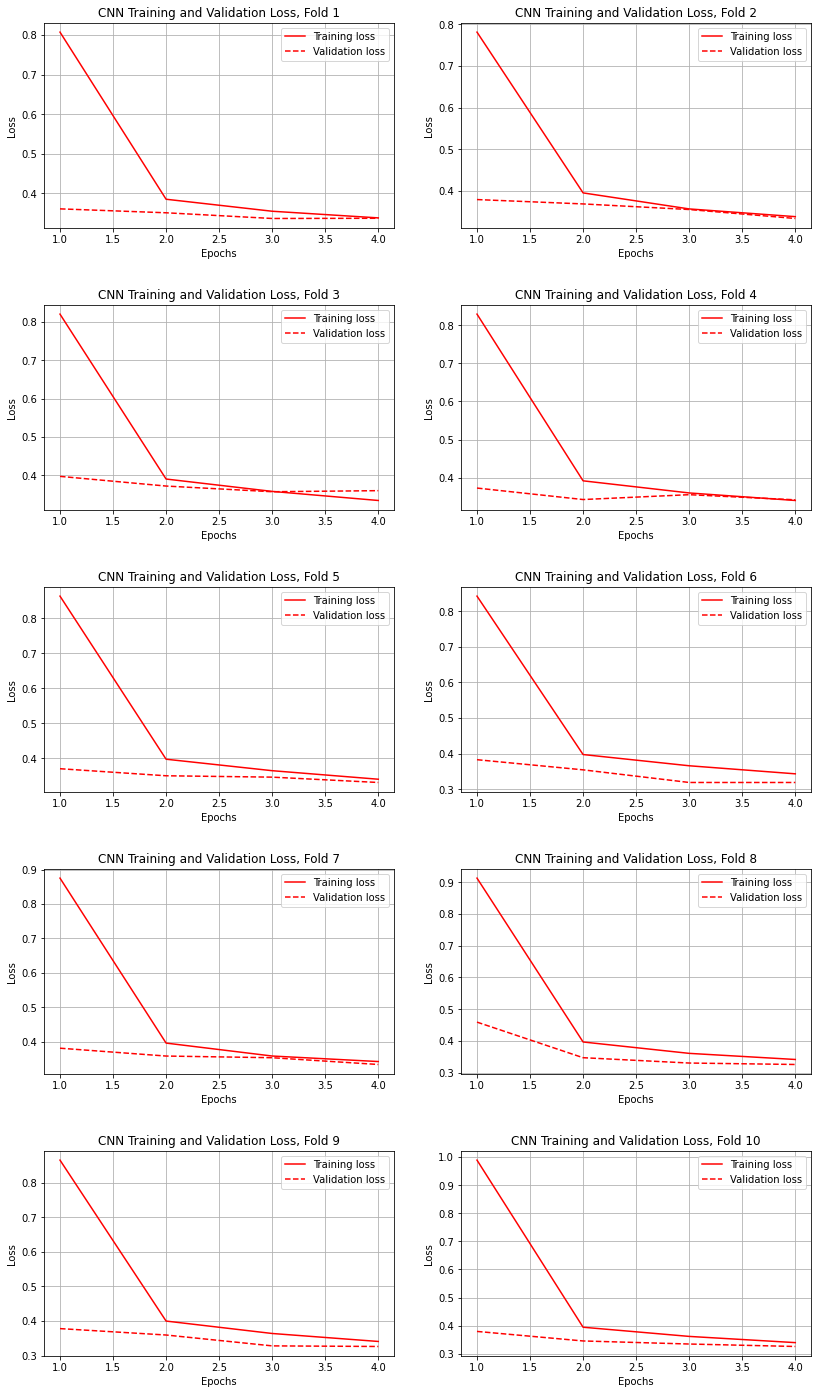

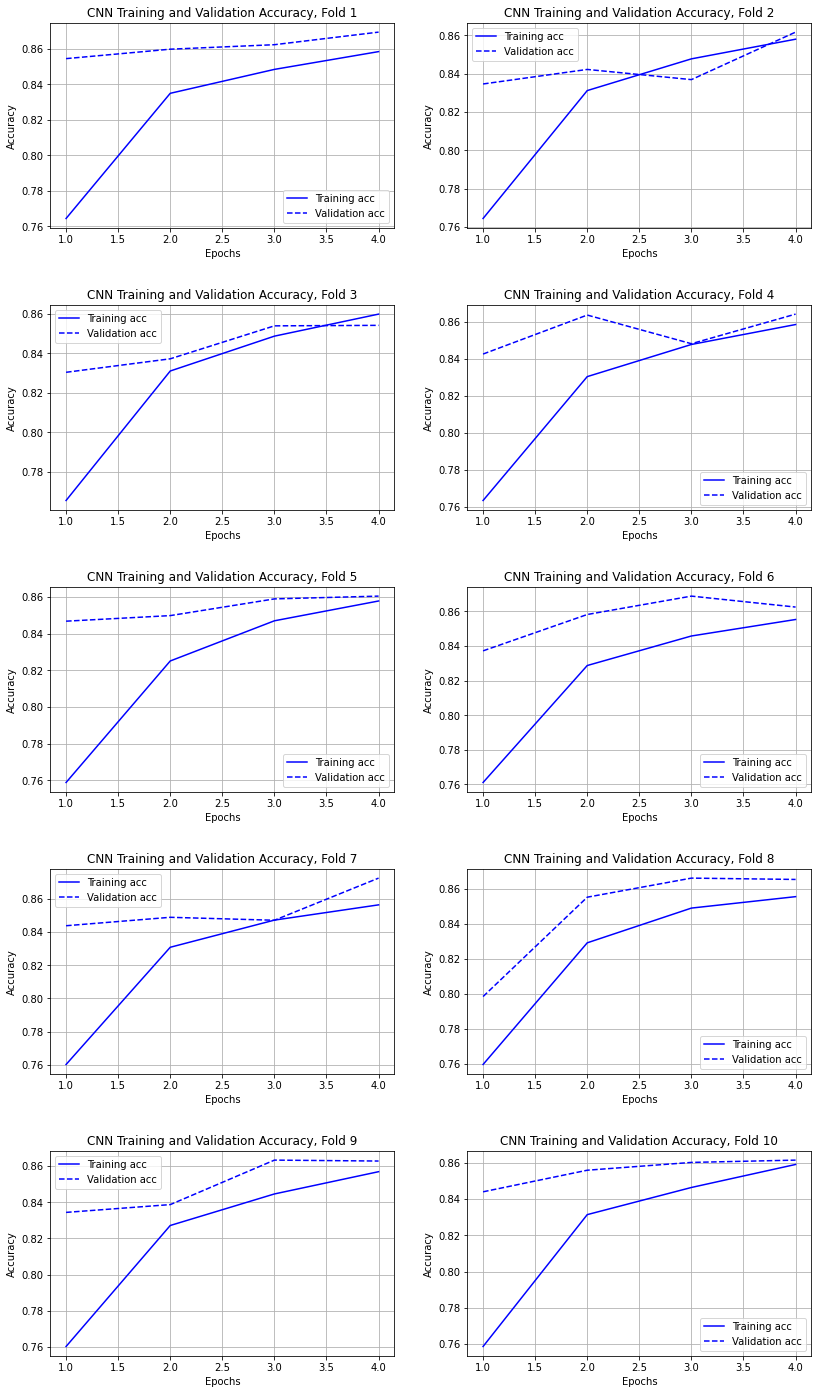

In [ ]:
import matplotlib.pyplot as plt

acc = []
val_acc = []
loss = []
val_loss = []

for i in range(len(results_history)):
  # history_dict = results_history[i].history
  history_dict = results_history[i]
  
  # print(history_dict.keys())

  acc.append(history_dict['accuracy'])
  val_acc.append(history_dict['val_accuracy'])
  loss.append(history_dict['loss'])
  val_loss.append(history_dict['val_loss'])
  


# # Loss Plot
epochs = range(1, len(acc[0]) + 1)
fig_row = -(-(len(acc)) // 2)
fig_col = 2
plt.rcParams['figure.figsize'] = [12, 20]
for i in range(len(loss)):
  plt.subplot(fig_row, fig_col, i+1)
  plt.plot(epochs, loss[i], 'r', label='Training loss')
  plt.plot(epochs, val_loss[i], 'r--', label='Validation loss')
  plt.title('CNN Training and Validation Loss, Fold {}'.format(i+1))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  # plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  # plt.minorticks_on()
plt.tight_layout(pad=3.0)
plt.savefig("./cnn/cnn_loss_10fold.png", format='png', dpi=150, bbox_inches='tight')
plt.show()


# # Accuracy Plot
plt.clf()   # clear figure
for i in range(len(acc)):
  plt.subplot(fig_row, fig_col, i+1)
  plt.plot(epochs, acc[i], 'b', label='Training acc')
  plt.plot(epochs, val_acc[i], 'b--', label='Validation acc')
  plt.title('CNN Training and Validation Accuracy, Fold {}'.format(i+1))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig("./cnn/cnn_accuracy_10fold.png", format='png', dpi=150, bbox_inches='tight')
plt.show()

Calculate Model Metrics
<br> Precision, Recall, Accuracy, F1-Score

In [ ]:
idx_best = 0
best_acc = 0

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Metrics Score per fold')
for i in range(0, len(all_accuracy)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1}')
  print('Accuracy: %f' % all_accuracy[i])
  print('Precision: %f' % all_precision[i])
  print('Recall: %f' % all_recall[i])
  print('F1 score: %f' % all_f1[i])
  if (all_accuracy[i] >= best_acc):
    idx_best = i
    best_acc = all_accuracy[i]
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Average Accuracy: {np.mean(np.asarray(all_accuracy))}')
print(f'> Average Precision: {np.mean(np.asarray(all_precision))}')
print(f'> Average Recall: {np.mean(np.asarray(all_recall))}')
print(f'> Average F1 Score: {np.mean(np.asarray(all_f1))}')
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')



------------------------------------------------------------------------
Metrics Score per fold
------------------------------------------------------------------------
> Fold 1
Accuracy: 0.869334
Precision: 0.880210
Recall: 0.922471
F1 score: 0.900846
------------------------------------------------------------------------
> Fold 2
Accuracy: 0.861737
Precision: 0.872894
Recall: 0.914194
F1 score: 0.893067
------------------------------------------------------------------------
> Fold 3
Accuracy: 0.854140
Precision: 0.844517
Recall: 0.941673
F1 score: 0.890453
------------------------------------------------------------------------
> Fold 4
Accuracy: 0.864016
Precision: 0.855026
Recall: 0.950588
F1 score: 0.900279
------------------------------------------------------------------------
> Fold 5
Accuracy: 0.860471
Precision: 0.896891
Recall: 0.887461
F1 score: 0.892151
------------------------------------------------------------------------
> Fold 6
Accuracy: 0.862497
Precision: 0.88888

Plot Precision-Recall Curve

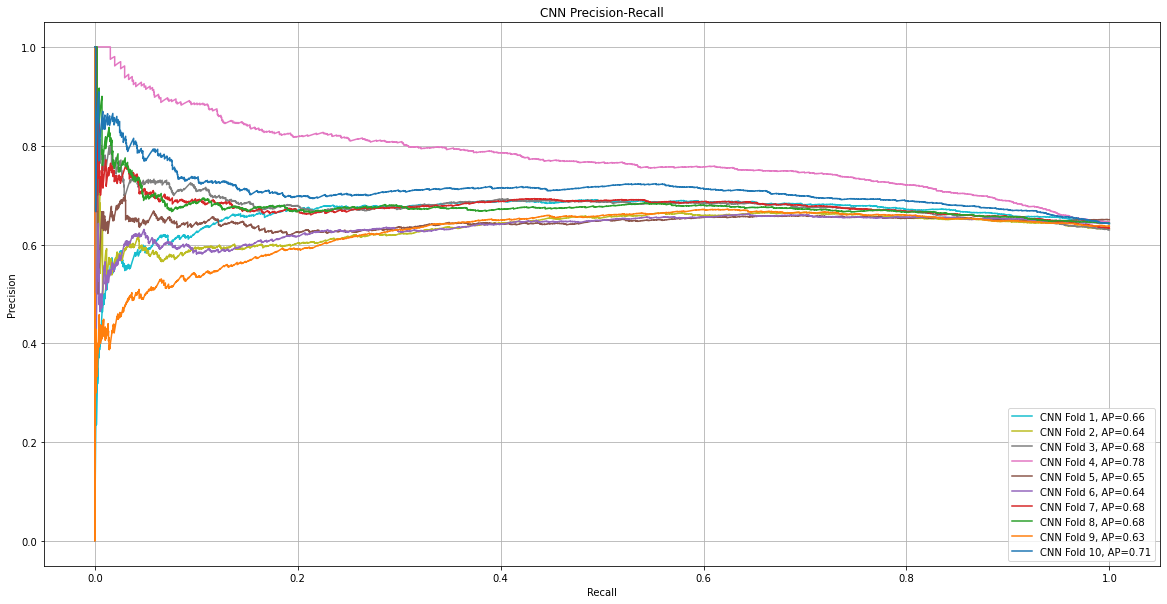

In [ ]:
import matplotlib.cm as cm

colors = cm.tab10_r(np.linspace(0, 1, len(all_arr_recall)))


plt.clf()   # clear figure
plt.rcParams['figure.figsize'] = [20, 10]

for i in range(len(all_arr_recall)):
  plt.plot(all_arr_recall[i], all_arr_precision[i], color=colors[i], label='CNN Fold {}, AP={:0.2f}'.format(i+1, all_ave_precision[i]))
  # plt.plot(np.linspace(0, 1, thresholds[i].size), thresholds[i], linestyle='--', label='Threshold')
plt.title('CNN Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=4)
plt.grid(True)
# plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plt.minorticks_on()
plt.savefig("./cnn/cnn_10fold_precision_recall.png", format='png', dpi=150, bbox_inches='tight')
plt.show()


Draw Confusion Matrix

In [ ]:
# unique, counts = np.unique(y_test_conv, return_counts=True)
# print(dict(zip(unique, counts)))
# cf_matrix = confusion_matrix(y_test_conv, yhat_classes)
# cf_matrix_best = all_cf_matrices[idx_best]
# print(cf_matrix_best)

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

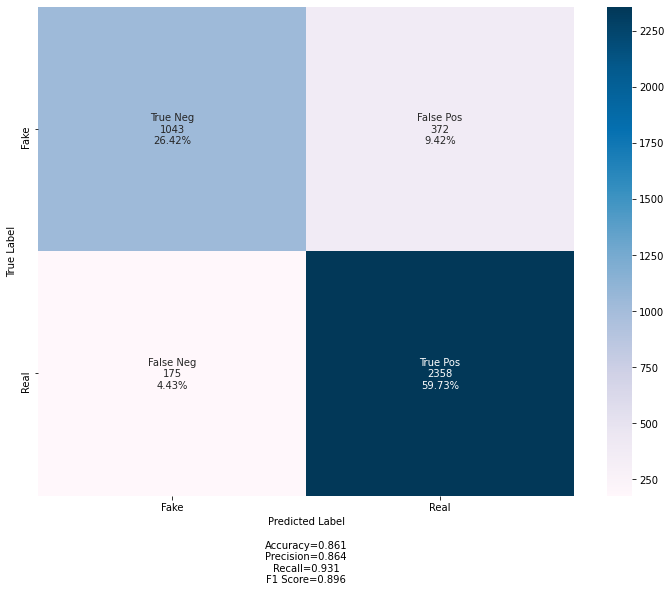

In [ ]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 9]
for j in range(len(all_cf_matrices)):
  cf_matrix_best = all_cf_matrices[j]

  stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                  all_accuracy[j],all_precision[j],all_recall[j],all_f1[j])

  group_names = ['True Neg','False Pos','False Neg','True Pos']

  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix_best.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix_best.flatten()/np.sum(cf_matrix_best)]

  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
            
  labels = np.asarray(labels).reshape(2,2)
  categories = ['Fake', 'Real']
  # cmap = sns.dark_palette("red")
  # cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
  # cmap = sns.color_palette("GnBu_d")

  plt.clf() 
  plt.figure()
  svm = sns.heatmap(cf_matrix_best, annot=labels, fmt='', cmap='PuBu',xticklabels=categories,yticklabels=categories)

  plt.ylabel('True Label')
  plt.xlabel('Predicted Label' + stats_text)

  # figure = svm.get_figure()    
  # figure.savefig('./cnn/cnn_conf_matrix.png', dpi=150)

  plt.savefig("./cnn/cfpr/cnn_best_10fold_conf_matrix_fold{}.png".format(j+1), format='png', dpi=150, bbox_inches='tight')

In [ ]:
for m in range(len(all_arr_precision)):
  df_prerec = pd.DataFrame(all_arr_precision[m])
  df_prerec.columns = ['precision']
  df_prerec['recall'] = all_arr_recall[m]
  df_prerec['threshold'] = all_thresholds[m]
  df_prerec
  df_prerec.to_pickle("./cnn/cfpr/cnn_best_10fold_precison_recall_curve_fold{}.pkl".format(m+1))

In [ ]:
!jupyter nbconvert --to html ./cnn/cnn_classification_malay_10fold.ipynb

[NbConvertApp] Converting notebook ./cnn/cnn_classification_malay_10fold.ipynb to html
[NbConvertApp] Writing 933497 bytes to ./cnn/cnn_classification_malay_10fold.html
